## Imports

In [1]:
import random
import pandas as pd
from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import plot_results, load_results
from gymnasium.wrappers import NormalizeObservation, NormalizeReward
import random
from pandas import Timestamp
import warnings

from flight_scheduling import FlightSchedulingEnv
from utils import generate_random_flight_schedule, generate_lambdas

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

## Generate flight schedule and lambdas

In [49]:
random_schedule = generate_random_flight_schedule(2)
random_schedule

,departure,arrival,way,airport,departure_minutes,arrival_minutes
0,1900-01-01 09:14:00,1900-01-01 10:27:00,-1,MAD,554,627
1,1900-01-01 09:49:00,1900-01-01 12:03:00,-1,JFK,589,723


In [3]:
schedule_0 = pd.DataFrame({
    'departure' : [Timestamp('1900-01-01 08:00:00'), Timestamp('1900-01-01 13:30:00')],
    'arrival' : [Timestamp('1900-01-01 10:00:00'), Timestamp('1900-01-01 14:30:00')],
    'way' : [-1, 1],
    'airport' : ['JFK', 'MAD'],
    'departure_minutes' : [480, 910],
    'arrival_minutes' : [600, 970],
})
schedule_0 

,departure,arrival,way,airport,departure_minutes,arrival_minutes,way_transformed
0,1900-01-01 08:00:00,1900-01-01 10:00:00,-1,JFK,480,600,0
1,1900-01-01 13:30:00,1900-01-01 14:30:00,1,MAD,910,970,1


In [4]:
lambdas = generate_lambdas(schedule_0)
lambdas = {'JFKMAD': 1000, 'MADJFK': 1000}
lambdas

{'JFKMAD': 1000, 'MADJFK': 1000}

## Custom environment

In [6]:
env = FlightSchedulingEnv(
    flight_schedule=schedule_0, 
    lambdas=lambdas, 
    max_steps=1000,
    revenue_estimation='basic'
)
env = NormalizeObservation(env)
#env = NormalizeReward(env)

## Random Policy

In [7]:
obs = env.reset()

for _ in range(10):
    action = env.action_space.sample()
    obs, reward, done, truncated, _ = env.step(action)
    print(action)
    print("Observation:", obs, "Reward:", reward)

env.close()

4
Observation: [0.00707103] Reward: 0.0
3
Observation: [1.38947339] Reward: 20.0
4
Observation: [0.98824311] Reward: 0.0
3
Observation: [1.59646272] Reward: 20.0
4
Observation: [1.22094393] Reward: 0.0
4
Observation: [1.02636198] Reward: 0.0
3
Observation: [1.63511522] Reward: 20.0
4
Observation: [1.35360445] Reward: 0.0
3
Observation: [1.75986964] Reward: 20.0
0
Observation: [1.93210602] Reward: -20.0


## RL Policy

In [8]:
env = FlightSchedulingEnv(
    flight_schedule=schedule_0, 
    lambdas=lambdas, 
    max_steps=1000,
    revenue_estimation='basic'
)
env = NormalizeObservation(env)
#env = NormalizeReward(env)

check_env(env)

In [61]:
model = PPO("MlpPolicy", env).learn(total_timesteps=100000)

In [63]:
for _ in range(10):
    obs, _ = env.reset()
    total_reward = 0
    done = False
    while not done:
        action, _ = model.predict(obs)
        #action = 0
        obs, reward, done, _, _ = env.step(action)
        #print('action : ', action)
        #print('obs : ', obs)
        #print('reward : ', reward)
        total_reward += reward
    print(total_reward)
env.close()

2600.0
2600.0
2600.0
2600.0
2600.0
2600.0
2600.0
2600.0
2600.0
2600.0


## Revenue estimation

In [2]:
env = FlightSchedulingEnv(
    flight_schedule=schedule_0,
    lambdas=lambdas,
    max_steps=100,
    revenue_estimation='classic'
)
env = NormalizeObservation(env)
#env = NormalizeReward(env)

NameError: name 'schedule_0' is not defined

In [67]:
model = PPO("MlpPolicy", env).learn(total_timesteps=100000)

In [68]:
for _ in range(10):
    obs, _ = env.reset()
    total_reward = 0
    done = False
    count = 0
    while not done:
        action, _ = model.predict(obs)
        '''if count < 9:
            action = 1
            count += 1
        else:
            action = 4
            count += 1'''
        obs, reward, done, _, _ = env.step(action)
        #print('action : ', action)
        #print('obs : ', obs)
        #print('reward : ', reward)
        total_reward += reward
    print(total_reward)
env.close()

250.0
250.0
250.0
250.0
250.0
250.0
250.0
222.22222222222217
250.0
222.22222222222217


In [23]:
from stable_baselines3.common.evaluation import evaluate_policy
import os
log_path = os.path.join('Training', 'Logs')
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path)
model.learn(total_timesteps=100)
evaluate_policy(model, env, n_eval_episodes=10, render=True)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to Training\Logs\PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -312     |
| time/              |          |
|    fps             | 2008     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------


(-736.1110916137695, 0.0)

# Random schedule

In [3]:
random_schedule = generate_random_flight_schedule(10)
random_schedule

,departure,arrival,way,airport,departure_minutes,arrival_minutes
0,1900-01-01 09:47:00,1900-01-01 10:54:00,-1,FCO,587,654
1,1900-01-01 12:29:00,1900-01-01 13:23:00,-1,MAD,749,803
2,1900-01-01 13:34:00,1900-01-01 15:32:00,-1,MAD,814,932
3,1900-01-01 14:46:00,1900-01-01 16:01:00,1,FCO,886,961
4,1900-01-01 14:55:00,1900-01-01 15:42:00,1,FCO,895,942
5,1900-01-01 15:22:00,1900-01-01 16:51:00,1,MAD,922,1011
6,1900-01-01 18:56:00,1900-01-01 21:16:00,1,JFK,1136,1276
7,1900-01-01 19:29:00,1900-01-01 20:34:00,1,FCO,1169,1234
8,1900-01-01 21:13:00,1900-01-01 23:27:00,1,JFK,1273,1407
9,1900-01-01 21:37:00,1900-01-01 23:20:00,-1,FCO,1297,1400


In [4]:
random_lambdas = generate_lambdas(random_schedule)
random_lambdas

{'FCOMAD': 1000,
 'MADFCO': 1000,
 'FCOJFK': 1000,
 'JFKFCO': 1000,
 'MADJFK': 1000,
 'JFKMAD': 1000}

In [16]:
env = FlightSchedulingEnv(
    flight_schedule=random_schedule,
    lambdas=random_lambdas,
    max_steps=1000,
    revenue_estimation='classic'
)
env = NormalizeObservation(env)
#env = NormalizeReward(env)

In [23]:
model = PPO("MlpPolicy", env).learn(total_timesteps=300000)

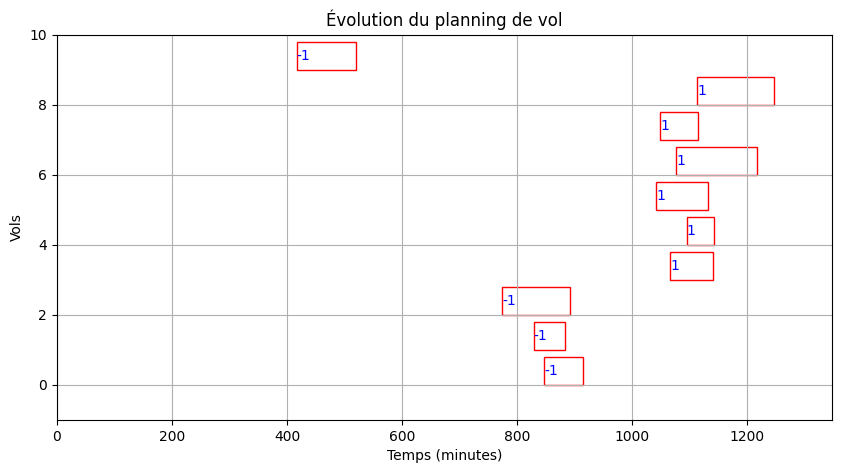

5273.611111111111


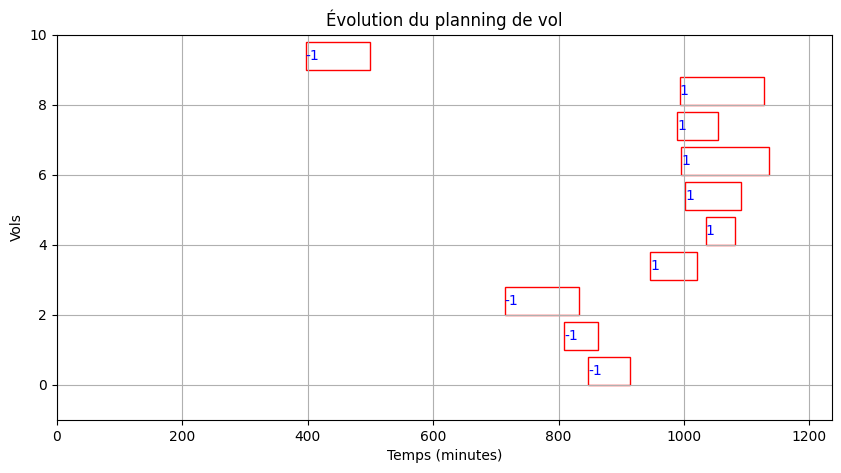

4776.388888888887


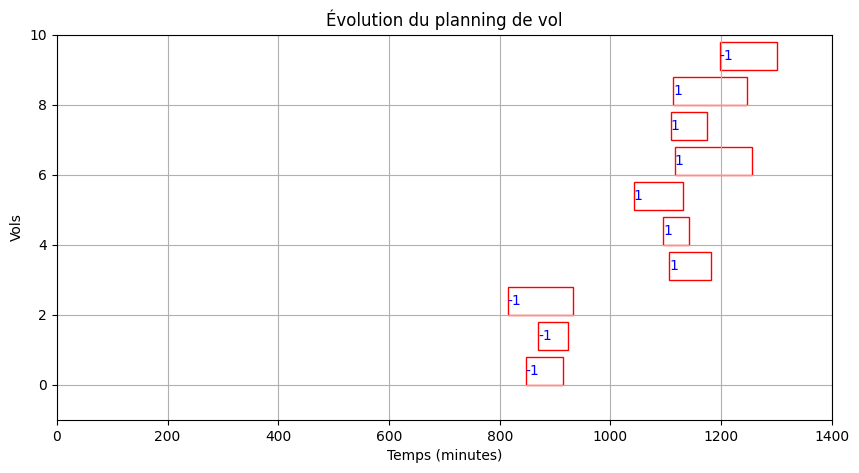

5384.722222222221


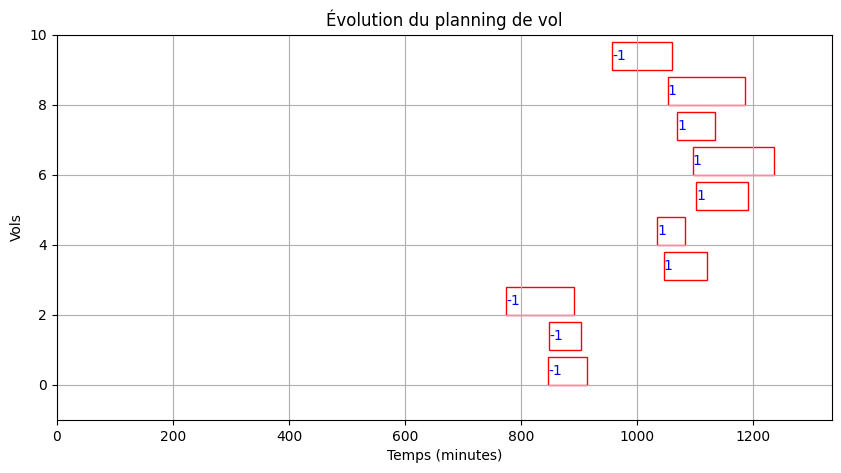

5662.499999999996


In [24]:
for _ in range(4):
    obs, _ = env.reset()
    #env.renderer()
    total_reward = 0
    done = False
    count = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _, _ = env.step(action)
        #print('action : ', action)
        #print('obs : ', obs)
        #print('reward : ', reward)
        total_reward += reward
    env.renderer(init=True)
    print(total_reward)
env.close()